<a href="https://colab.research.google.com/github/CGrannan/building-boardgame-recommendation-systems/blob/master/collaborative_filtering_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the last notebook we used natural language processing to create a content-based recommendation system for boardgames. To continue, we will now start to use user ratings to develop collaborative-filtering recommendation systems.  To begin we will load in our libraries, functions and data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
from os import listdir

import datetime

In [ ]:
% run /content/drive/MyDrive/CapstoneProject/collaborative_filtering.py

Our data for this part of the project consists of the 38 csv files of ratings that we previously scraped.  We will load them now.

In [ ]:
filepaths = [('/content/drive/MyDrive/CapstoneProject/scraped_ratings/' + f) for f in listdir('/content/drive/MyDrive/CapstoneProject/scraped_ratings') if f.endswith('.csv')]
reviews = pd.concat([pd.read_csv(filepath, delimiter='\t', header=None) for filepath in filepaths], axis=0)
reviews.columns = ['game_id', 'user', 'rating', 'comment']
reviews.head()

,game_id,user,rating,comment
0,822,rougemacabre,10.0,Very easy rules and quick to pick up. Good for...
1,822,InvalidLitDepot,10.0,"So simple, but so addictive and fun"
2,822,jhilahd,10.0,NaN
3,822,qwertyalex,10.0,NaN
4,822,MingStar,10.0,NaN


In [ ]:
len(reviews)

3751793

# Data Cleaning

Now that we have our data loaded up, we will need to clean it. The first thing we want to do is drop the users who have not rated at least 50 games. By dropping the users who have rated fewer games, we are more likely to achieve a significant result.

In [ ]:
more_than_50_reviews = reviews[reviews['user'].map(reviews['user'].value_counts()) >= 50]
len(more_than_50_reviews)

1591118

In [ ]:
more_than_50_reviews.user.value_counts()

Tolkana          1200
Doel             1198
RichardIngram    1027
TomVasel          936
Walt Mulder       878
                 ... 
zaczaczaczac       50
tarrkid            50
vakrel             50
hunterturtle       50
duncanvalley       50
Name: user, Length: 16280, dtype: int64

We started with 2000 reviews for each game, but now that we have dropped about half of our reviews that is likely to have changed. Let's check what our review counts look like for each game and drop the games that don't have at least 200 reviews.

In [ ]:
more_than_50_reviews.game_id.value_counts()

40760     1446
38992     1434
125       1430
34707     1420
15290     1417
          ... 
50381      191
234190     188
230914     187
204053     166
1927       163
Name: game_id, Length: 2000, dtype: int64

In [ ]:
more_than_50_reviews = more_than_50_reviews[more_than_50_reviews['game_id'].map(more_than_50_reviews['game_id'].value_counts()) >= 200]
len(more_than_50_reviews)

1589831

In [ ]:
len(more_than_50_reviews.game_id.unique())

1993

We also will not be using the comments on the ratings for this project, so we can drop those as well.

In [ ]:
more_than_50_reviews = more_than_50_reviews.drop(['comment'], axis=1)

Let's check the value counts for our rating column to see how the different ratings are distributed. I expect to have more positive reviews than negative reviews because of our scraping process.

In [ ]:
more_than_50_reviews.rating.value_counts()

8.0000     391624
7.0000     290919
9.0000     245330
10.0000    157600
6.0000     116799
            ...  
9.5402          1
9.5970          1
7.5899          1
6.6090          1
8.2940          1
Name: rating, Length: 3445, dtype: int64

There are some weird decimals here when the ratings should be 1-10. Some of these seem to be aggregates from groups of reviewers. Let's round the values to make them even.

In [ ]:
more_than_50_reviews.rating = round(more_than_50_reviews.rating, 0)
more_than_50_reviews.rating.value_counts()

8.0     585013
7.0     320551
9.0     272587
10.0    185075
6.0     162965
5.0      37848
4.0      15125
3.0       6347
2.0       2863
1.0       1457
Name: rating, dtype: int64

Next, we will load in our statistics dataframe and retrieve the name and game_id columns. This will be used in some our functions to retrieve recommendations.

In [ ]:
game_df = pd.read_pickle('/content/drive/MyDrive/CapstoneProject/games_with_descriptions')
game_df = game_df.reset_index().rename(columns={'index':'game_id'})
game_df = game_df[['game_id', 'name']]
game_df.head()

,game_id,name
0,1,Die Macher
1,2,Dragonmaster
2,3,Samurai
3,4,Tal der Könige
4,5,Acquire


Next, we will create a pivot table to convert our ratings into a MxN matrix. We will have our user names as column names, our game_ids as our index, and our ratings as values.

In [ ]:
reviews_pvt = pd.pivot_table(more_than_50_reviews, values='rating', index='game_id', columns='user')
reviews_pvt.head()

user,-=Yod@=-,-Johnny-,-mIDE-,0b1_Ita,0ddjob,0hoHj,0xDEADBEEF,1 Family Meeple,1000games,1000rpm,100pcBlade,105JS2687S2003,13walker,144creations,1979 AMC Treo 755p,19jake91,1Aspielerin,1Mmirg,1agerace1,1awesomeguy,1nf1n1ty,1point21gigawatts,1qwerty,20hz20khz,210pasadena,22764636,26october,28green,2bit,2bpencil,2d20,2dTones,2ndPlace,2ombie,33cb,3davoli,3dicebombers,3dragonfly,3ldfilms,42amu,...,zolle001,zollom04,zomar1,zombie plumber,zombie_cataclysm,zombiegod,zomborya,zondo,zontziry,zopie71,zorac,zorrochristian,zosa,zottirgen,zoul0813,zowieso,zrobin,zsknight,zublord,zubor,zuk1958,zulcus,zumba,zumikon,zunnesteke,zunyer,zurita7,zurn,zuxxux,zuzusdad,zweken,zwinky,zwobot,zx80,zybthranger,zydoz,zyklonc,zyrus,zyx0xyz,zztap
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
7,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,6.0,NaN,7.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,9.0,NaN,NaN,NaN,NaN


I'm going to create a copy of the pivot table and reset the index. This will allow us to more easily access the pivot table moving forward. We will also fill our null values now with zeroes and convert our user names to user_ids.

In [ ]:
game_id_pvt = reviews_pvt.reset_index()
game_id_pvt.head()

user,game_id,-=Yod@=-,-Johnny-,-mIDE-,0b1_Ita,0ddjob,0hoHj,0xDEADBEEF,1 Family Meeple,1000games,1000rpm,100pcBlade,105JS2687S2003,13walker,144creations,1979 AMC Treo 755p,19jake91,1Aspielerin,1Mmirg,1agerace1,1awesomeguy,1nf1n1ty,1point21gigawatts,1qwerty,20hz20khz,210pasadena,22764636,26october,28green,2bit,2bpencil,2d20,2dTones,2ndPlace,2ombie,33cb,3davoli,3dicebombers,3dragonfly,3ldfilms,...,zolle001,zollom04,zomar1,zombie plumber,zombie_cataclysm,zombiegod,zomborya,zondo,zontziry,zopie71,zorac,zorrochristian,zosa,zottirgen,zoul0813,zowieso,zrobin,zsknight,zublord,zubor,zuk1958,zulcus,zumba,zumikon,zunnesteke,zunyer,zurita7,zurn,zuxxux,zuzusdad,zweken,zwinky,zwobot,zx80,zybthranger,zydoz,zyklonc,zyrus,zyx0xyz,zztap
0,1,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
3,7,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,6.0,NaN,7.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN
4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,9.0,NaN,NaN,NaN,NaN


In [ ]:
pvt_filled = reviews_pvt.fillna(0)
user_ids = [(i+1) for i in range(len(more_than_50_reviews.user.unique()))]
pvt_filled.columns = user_ids
pvt_filled.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,16241,16242,16243,16244,16245,16246,16247,16248,16249,16250,16251,16252,16253,16254,16255,16256,16257,16258,16259,16260,16261,16262,16263,16264,16265,16266,16267,16268,16269,16270,16271,16272,16273,16274,16275,16276,16277,16278,16279,16280
game_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
7,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,6.0,0.0,7.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,9.0,0.0,0.0,0.0,0.0


# EDA

Great, our data is all cleaned and ready for modeling, but let's look at some of our distributions a little closer first. First up, I want to look at how are rating levels are distributed. We should be expecting a lot of high values as we took the highest rated reviews for each game when we scraped our data.

Text(0, 0.5, 'Percentage of Sample')

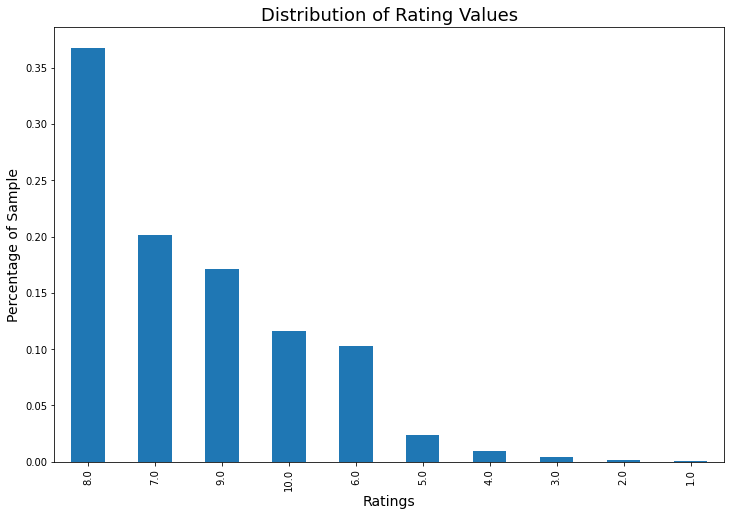

In [ ]:
fig = plt.figure(figsize=(12,8))
more_than_50_reviews.rating.value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Rating Values', fontsize=18)
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Percentage of Sample', fontsize=14)

As expected the vast majority of our games are above 5 out of a 10 point rating. Furthermore, we have a lot of 8 point ratings. This will be important to consider when we evaluate our models.

Next we should look at the review counts for each game.

([<matplotlib.axis.XTick at 0x7f8a502ce2b0>,
 [Text(0, 0, '1'),
  Text(0, 0, '354'),
  Text(0, 0, '1231'),
  Text(0, 0, '3076'),
  Text(0, 0, '9028'),
  Text(0, 0, '18098'),
  Text(0, 0, '26990'),
  Text(0, 0, '35815'),
  Text(0, 0, '46213'),
  Text(0, 0, '71906'),
  Text(0, 0, '102794'),
  Text(0, 0, '124172'),
  Text(0, 0, '139030'),
  Text(0, 0, '151347'),
  Text(0, 0, '163967'),
  Text(0, 0, '175239'),
  Text(0, 0, '191189'),
  Text(0, 0, '204472'),
  Text(0, 0, '224517'),
  Text(0, 0, '246784')])

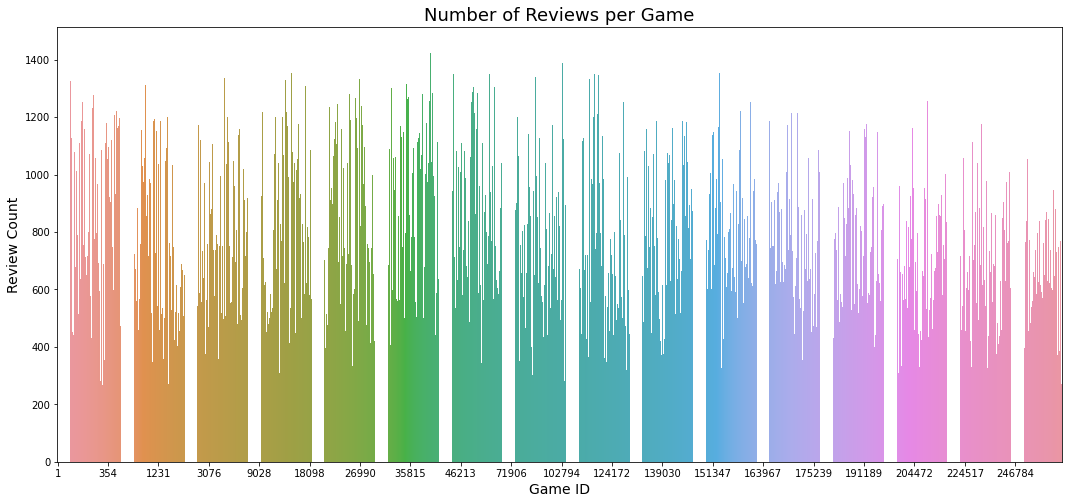

In [ ]:
fig = plt.figure(figsize=(18,8))
g = sns.barplot(x = reviews_pvt.index, y = reviews_pvt.notna().sum(axis=1))
plt.title('Number of Reviews per Game', fontsize=18)
plt.xlabel('Game ID', fontsize = 14)
plt.ylabel('Review Count', fontsize=14)

new_ticks = [i.get_text() for i in g.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 100), new_ticks[::100])

this graph is a little busy, but we get the general idea of the distribution. Just to make it a bit clearer, I am going to bin our values and regraph them.

In [ ]:
num_ratings_by_game = more_than_50_reviews.groupby('game_id').count()['rating'].copy()
num_ratings_by_game.sort_values(inplace = True)

stops_for_review_counts = [1, 200, 400, 600, 800, 1000, 1200, 1400, 1600]
review_count_bins = {}


for index in range(1, len(stops_for_review_counts)):
    review_count_bins[str(stops_for_review_counts[index - 1]) + ' - ' + str(stops_for_review_counts[index])] = \
        len(num_ratings_by_game[(num_ratings_by_game > stops_for_review_counts[index - 1]) & \
            (num_ratings_by_game <= stops_for_review_counts[index])])

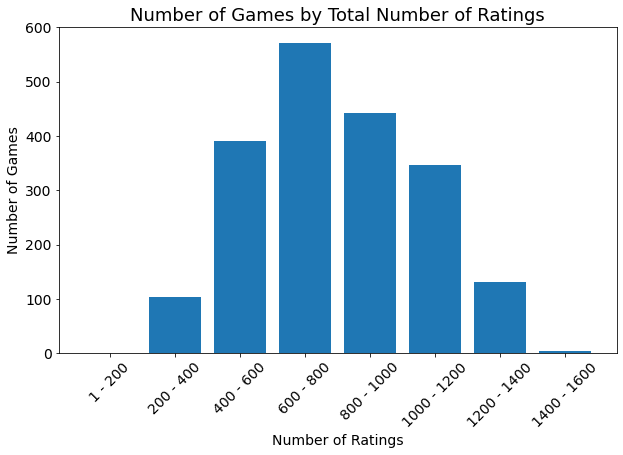

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(review_count_bins.keys(), review_count_bins.values())
plt.tick_params(axis = 'x', labelsize = 14, rotation = 45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('Number of Ratings', fontsize = 14)
plt.ylabel('Number of Games', fontsize = 14)
plt.title('Number of Games by Total Number of Ratings', fontsize = 18)
plt.show()

Thats better. We actually have a fairly normally distributed number of ratings per game with most games having between 600 and 1000 reviews. Next up let's look at the average rating of each game.

([<matplotlib.axis.XTick at 0x7f8a507ec9b0>,
 [Text(0, 0, '1'),
  Text(0, 0, '354'),
  Text(0, 0, '1231'),
  Text(0, 0, '3076'),
  Text(0, 0, '9028'),
  Text(0, 0, '18098'),
  Text(0, 0, '26990'),
  Text(0, 0, '35815'),
  Text(0, 0, '46213'),
  Text(0, 0, '71906'),
  Text(0, 0, '102794'),
  Text(0, 0, '124172'),
  Text(0, 0, '139030'),
  Text(0, 0, '151347'),
  Text(0, 0, '163967'),
  Text(0, 0, '175239'),
  Text(0, 0, '191189'),
  Text(0, 0, '204472'),
  Text(0, 0, '224517'),
  Text(0, 0, '246784')])

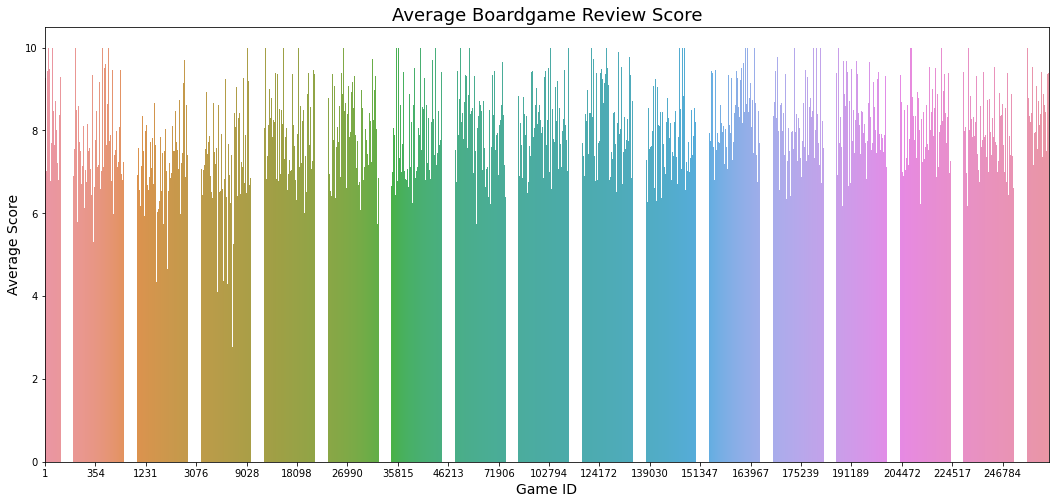

In [ ]:
fig = plt.figure(figsize=(18,8))
g = sns.barplot(x = reviews_pvt.index, y = reviews_pvt.mean(axis=1))
plt.title('Average Boardgame Review Score', fontsize=18)
plt.xlabel('Game ID', fontsize=14)
plt.ylabel('Average Score', fontsize=14)

new_ticks = [i.get_text() for i in g.get_xticklabels()]
plt.xticks(range(0, len(new_ticks), 100), new_ticks[::100])

Most of our games have a very high average score. this is to be expected because of how we sampled our data. Again, this will be important to keep in mind when we assess our models.

Next up, let's look at the number of ratings from each user.

Text(0, 0.5, 'Review Count')

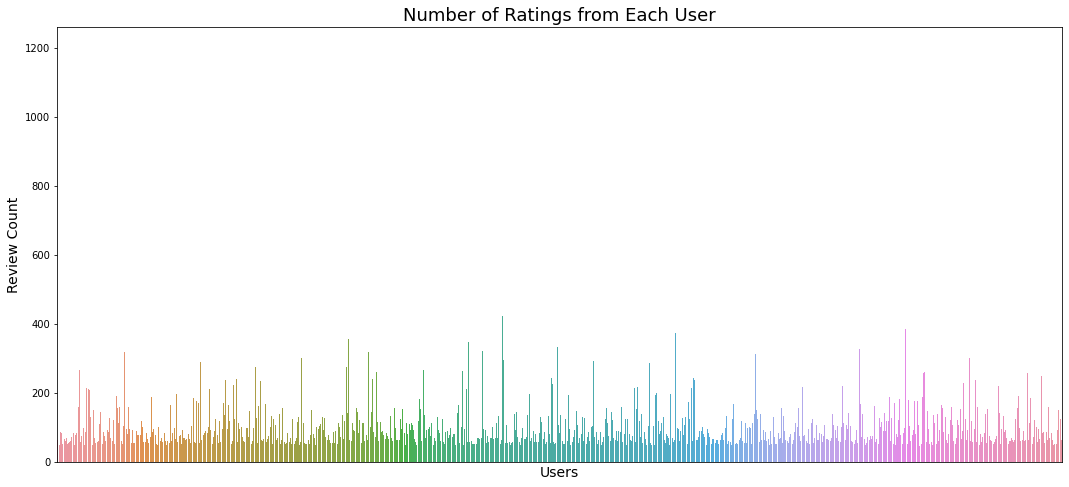

In [ ]:
fig = plt.figure(figsize=(18,8))
g = sns.barplot(x = reviews_pvt.columns, y = [sum(reviews_pvt[column] > 0) for column in reviews_pvt.columns])
g.set(xticks=[])
plt.title('Number of Ratings from Each User', fontsize=18)
plt.xlabel('Users', fontsize=14)
plt.ylabel('Review Count', fontsize=14)


Again this graph is pretty busy, so we will bin our values to give them a bit more meaning.

In [ ]:
num_ratings_by_user = more_than_50_reviews.groupby('user').count()['rating'].copy()
num_ratings_by_user.sort_values(inplace = True)

stops_for_review_counts = [1, 100, 200, 400, 1300]
review_count_bins = {}


for index in range(1, len(stops_for_review_counts)):
    review_count_bins[str(stops_for_review_counts[index - 1]) + ' - ' + str(stops_for_review_counts[index])] = \
        len(num_ratings_by_user[(num_ratings_by_user > stops_for_review_counts[index - 1]) & \
            (num_ratings_by_user <= stops_for_review_counts[index])])

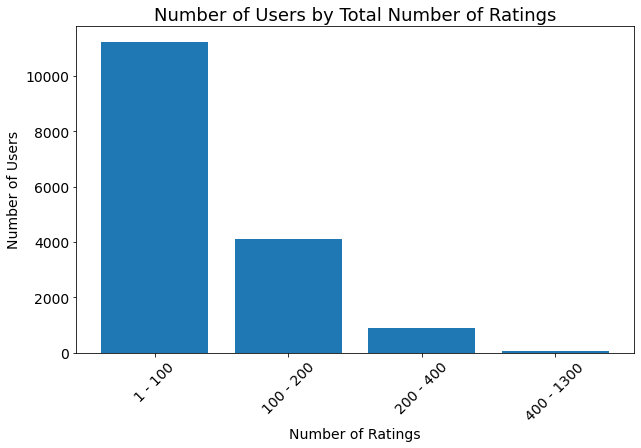

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(review_count_bins.keys(), review_count_bins.values())
plt.tick_params(axis = 'x', labelsize = 14, rotation = 45)
plt.tick_params(axis = 'y', labelsize = 14)
plt.xlabel('Number of Ratings', fontsize = 14)
plt.ylabel('Number of Users', fontsize = 14)
plt.title('Number of Users by Total Number of Ratings', fontsize = 18)
plt.show()

The vast majority of our reviewers have rated fewer than 100 games. This isn't too surprising as that is a lot of board game, but it does show how sparse our matrix is. To improve our model's accuracy we will need to add more data eventually.

Finally, let's look at the average ratign from each user. Again, I expect these numbers to be relatively high due to our scraping method.

Text(0, 0.5, 'Average Rating')

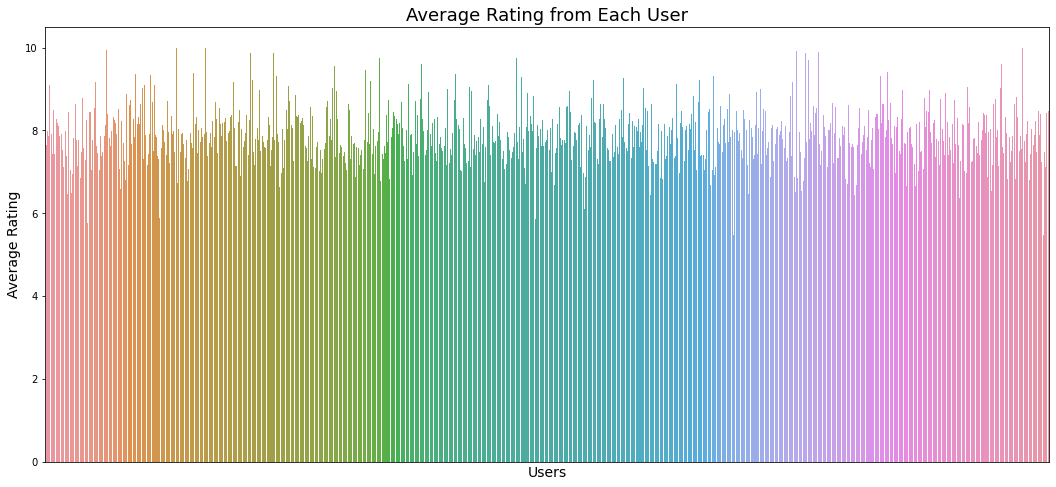

In [ ]:
fig = plt.figure(figsize=(18,8))
g = sns.barplot(x = reviews_pvt.columns, y = [reviews_pvt[column].mean() for column in reviews_pvt.columns])
g.set(xticks=[])
plt.title('Average Rating from Each User', fontsize=18)
plt.xlabel('Users', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)

As expected our average rating for each user fluctuates around 8 points.  Once again, the presence of so many high ratings will need to be considered when we are analyzing our results.

# Modeling - Model Based Collaborative Filtering

Now we are ready to begin modeling. For this notebook, we will be looking at building two rather simple models. We will build a K-nearest neighbors model and a singular value decomposition model, both using sci-kit learn. We will start with the KNN model.

First we create a NearestNeighbors instance. We will use cosine as our distance metric as we are looking to calculate the cosine similarity and not a proper distance measure.

In [ ]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(pvt_filled)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Next we will use a handy function we wrote to retrieve recommendations. Our function will convert the name of a game into an id, find the 5 games with the most similar ratings and convert their ids back into the names of the games. We will pull recommendations for three games to make sure we are getting unique entries.

In [ ]:
get_knn_recommendations('Gloomhaven', model_knn, game_df, game_id_pvt, pvt_filled)

Recommendations for Gloomhaven:

1: Gloomhaven: Jaws of the Lion, with distance of 0.8302014392979479:
2: Spirit Island, with distance of 0.8408221723065283:
3: Aeon's End: Legacy, with distance of 0.8472333914652613:
4: Founders of Gloomhaven, with distance of 0.8482777123514965:
5: The City of Kings, with distance of 0.8491417494404531:


In [ ]:
get_knn_recommendations('Carcassonne', model_knn, game_df, game_id_pvt, pvt_filled)

Recommendations for Carcassonne:

1: Carcassonne: Expansion 1 – Inns & Cathedrals, with distance of 0.6532546748829806:
2: Carcassonne: Expansion 2 – Traders & Builders, with distance of 0.6727079114202036:
3: Carcassonne: The River, with distance of 0.8073784579172465:
4: Carcassonne: Hunters and Gatherers, with distance of 0.8109385834944663:
5: Carcassonne: King & Scout, with distance of 0.8152920092344547:


In [ ]:
get_knn_recommendations('Monopoly', model_knn, game_df, game_id_pvt, pvt_filled)

Recommendations for Monopoly:

1: Risk, with distance of 0.7692131015852246:
2: Clue, with distance of 0.8152203784505146:
3: UNO, with distance of 0.8266588322479786:
4: Battleship, with distance of 0.8310712723058971:
5: The Game of Life, with distance of 0.8434296211907355:


Our recommendations look really good here. Gloomhaven returned two games that take place in the same world and other games of similar complexity and themes. Carcassonne returned several expansions, which are games that are very similar to the base game. And monopoly returned several clasic board games which makes a lot of sense. For such a simple model I am very happy with these results.

Now let's build a SVD model. First up we will create a Truncated SVD instance and transform our pivot table into a sparse matrix. I played with the n_components parameter to find the best fit, and I was happiest with using 20.

In [ ]:
np.random.seed(123)

svd = TruncatedSVD(n_components=20)
matrix = svd.fit_transform(pvt_filled)
matrix.shape

(1993, 20)

Next we calculate the similarity matrix

In [ ]:
corr = np.corrcoef(matrix)
corr.shape

(1993, 1993)

Finally, we assign a game that we want to pull reviews for and look at where we have the highest ratings. Here we will look at the recommendations for Gloomhaven, where the similarity is above a .9.

In [ ]:
gloom_id = 1487
ids = pvt_filled.index
recs = list(ids[corr[gloom_id] > .9])
recs

[55690, 162886, 174430, 205637]

We got back the ids for Kingdom Death: Monster, Spirit Island, Too Many Bones and Arkham Horror: the Card Game. All of these are pretty decent recomendations as they are all fairly heavy thematic games. I cleaned this process up into a handy function we can use, as seen below.

In [ ]:
get_svd_recommendations('Gloomhaven', stats_df=game_df, pvt_table=pvt_filled, pvt_table2=game_id_pvt)

Kingdom Death: Monster
Spirit Island
Gloomhaven
Too Many Bones
Arkham Horror: The Card Game


In [ ]:
get_svd_recommendations('Carcassonne', stats_df=game_df, pvt_table=pvt_filled, pvt_table2=game_id_pvt)

Carcassonne
Carcassonne: Expansion 1 – Inns & Cathedrals
Carcassonne: Expansion 2 – Traders & Builders


In [ ]:
get_svd_recommendations('Monopoly', stats_df=game_df, pvt_table=pvt_filled, pvt_table2=game_id_pvt)

Risk
Scrabble
Scotland Yard
Phase 10
Clue
Monopoly
Stratego
UNO
Yahtzee
Battleship


This method is a little more cumbersome than the KNN model as it is random and thus changes everytime we make the matrix. Also, the way that we have the model set up it doesn't return a set number of games, but rather games that are above a certain threshhold. We could change the output, but I find this more informative.

# Analysis

Both models provided decent recommendations. I like the KNN recommendations for monopoly and the svd model for Gloomhaven. Both sets of recommendations for Carcassonne consisted entirely of expansions, so they were basically the same.  As far as preference as a whole, I would choose the KNN model as it is a little more efficient to implement, though the implementation of the SVD model could be enhanced. Ultimately I would recommend getting user feedback on the outputs of both models to determine a better choice.

So far we have looked at models that provide recommendations for individual games. None of the models that we have built so far support the creation of new users or recommendations for users. In the next notebook we will build a recommendation system that will allow us to do these things.

# Demo

If you run the cell below, you can enter a game's name and see recommendations from both systems.

In [ ]:
get_recommendations(model_knn, game_df, game_id_pvt, pvt_filled)

Enter game for recommendations: Monopoly


KNN Recommendations
Recommendations for Monopoly:

1: Risk, with distance of 0.7692131015852246:
2: Clue, with distance of 0.8152203784505146:
3: UNO, with distance of 0.8266588322479786:
4: Battleship, with distance of 0.8310712723058971:
5: The Game of Life, with distance of 0.8434296211907355:


SVD Recommendations
Risk
Scrabble
Mille Bornes
Phase 10
Clue
Monopoly
Stratego
UNO
Yahtzee
Battleship
The Game of Life
Get more recommendations? y/n: n
